# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import watermark
import missingno as msn
import warnings
%reload_ext watermark
warnings.filterwarnings('ignore')


In [252]:
%watermark -a 'Guilherme'

Author: Guilherme



In [253]:
%watermark --iversion

watermark : 2.5.0
seaborn   : 0.13.2
tqdm      : 4.66.5
numpy     : 1.26.4
matplotlib: 3.9.2
missingno : 0.5.2
pandas    : 2.2.2



# Carregando do dataset

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head()

,id,data_lancamento,conta_debito,conta_credito,valor,documento,natureza_operacao,centro_custo,impostos,moeda,taxa_conversao
0,1,2022-02-27,DWAVRL,CIOVQ6,5533.25,DOCPAXGQ,OP7JDVK,CC5FYA2,444.13252,NaN,3.475606
1,2,2022-05-11,D8TF53,CV9Y0V,7180.37,DOCBXZXG,OPXSY64,CCLH4R9,471.09236,EUR,3.523287
2,3,2020-03-23,D0TZCE,CELQSH,6067.36,DOCF5ITC,OPTDE9B,CCDG8CJ,326.49988,JPY,3.523287
3,4,2021-06-14,DOGLK7,CDFEMS,5494.34,DOCZRS1U,NaN,CC98G2K,471.09236,JPY,3.523287
4,5,2022-11-13,DHL0I5,CRU97G,4294.18,NaN,OP62LG1,CCZD80Y,154.26398,EUR,3.523287


# Análise exploratória - Antes da limpeza

In [4]:
# Estrutura de dados
df.shape

(1200, 11)

In [5]:
# Metadados das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1200 non-null   int64  
 1   data_lancamento    1200 non-null   object 
 2   conta_debito       1200 non-null   object 
 3   conta_credito      1200 non-null   object 
 4   valor              1200 non-null   float64
 5   documento          1078 non-null   object 
 6   natureza_operacao  1080 non-null   object 
 7   centro_custo       1200 non-null   object 
 8   impostos           1020 non-null   float64
 9   moeda              947 non-null    object 
 10  taxa_conversao     982 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 103.3+ KB


In [6]:
# Função para verificar os valores ausentes para cada coluna

def verifica_ausentes(df):

    qtd = pd.DataFrame(df.isna().sum()).rename(columns={0:'Qtd'})
    percent = pd.DataFrame(round(qtd / df.shape[0] * 100,2)).rename(columns={'Qtd':'Percent'})
    tbl_ausentes = pd.concat([qtd,percent], axis=1).reset_index().rename(columns={'index':'Atributo'})

    return tbl_ausentes

In [7]:
# Verificando os ausentes
verifica_ausentes(df)

,Atributo,Qtd,Percent
0,id,0,0.00
1,data_lancamento,0,0.00
2,conta_debito,0,0.00
3,conta_credito,0,0.00
4,valor,0,0.00
5,documento,122,10.17
6,natureza_operacao,120,10.00
7,centro_custo,0,0.00
8,impostos,180,15.00
9,moeda,253,21.08


<Axes: >

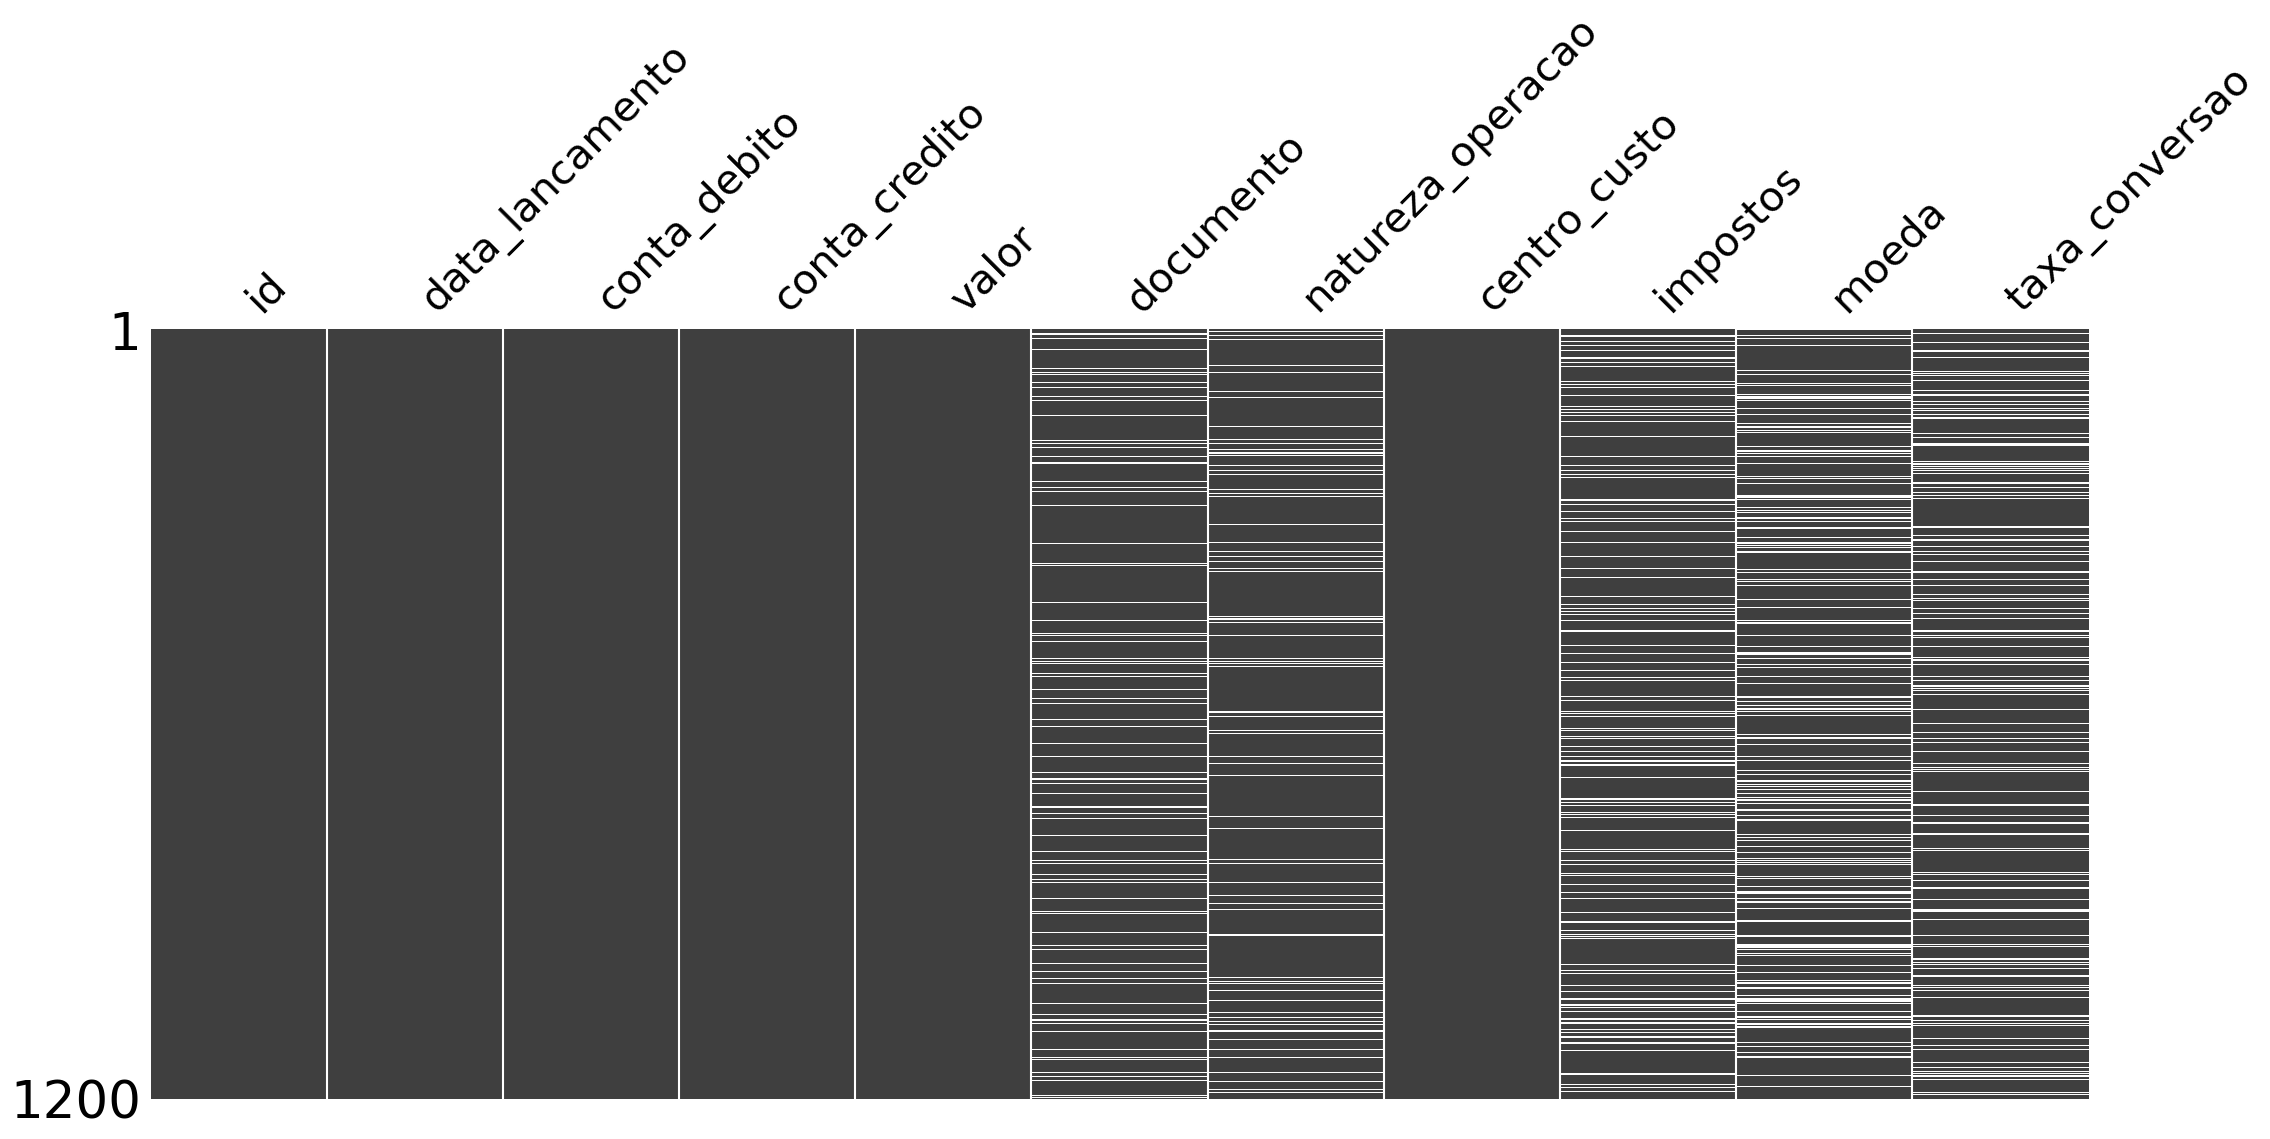

In [8]:
# Verificando a distribuição dos ausentes graficamente
msn.matrix(df,sparkline=False, fontsize=30)

## Medidas estatisticas antes dos tratamentos

In [9]:
df.describe(include='all')

,id,data_lancamento,conta_debito,conta_credito,valor,documento,natureza_operacao,centro_custo,impostos,moeda,taxa_conversao
count,1200.000000,1200,1200,1200,1200.000000,1078,1080,1200,1020.000000,947,982.000000
unique,NaN,808,1200,1197,NaN,1078,1080,1200,NaN,4,NaN
top,NaN,2023-07-18,DWAVRL,?,NaN,DOCPAXGQ,OP7JDVK,CC5FYA2,NaN,BRL,NaN
freq,NaN,5,1,4,NaN,1,1,1,NaN,240,NaN
mean,600.500000,NaN,NaN,NaN,10094.975148,NaN,NaN,NaN,604.264546,NaN,2.601499
std,346.554469,NaN,NaN,NaN,25595.942955,NaN,NaN,NaN,1116.015868,NaN,0.853906
min,1.000000,NaN,NaN,NaN,105.410000,NaN,NaN,NaN,154.263980,NaN,1.248029
25%,300.750000,NaN,NaN,NaN,2631.245000,NaN,NaN,NaN,326.499880,NaN,2.135300
50%,600.500000,NaN,NaN,NaN,5092.510000,NaN,NaN,NaN,430.155339,NaN,2.568117
75%,900.250000,NaN,NaN,NaN,7881.407500,NaN,NaN,NaN,444.132520,NaN,3.475606


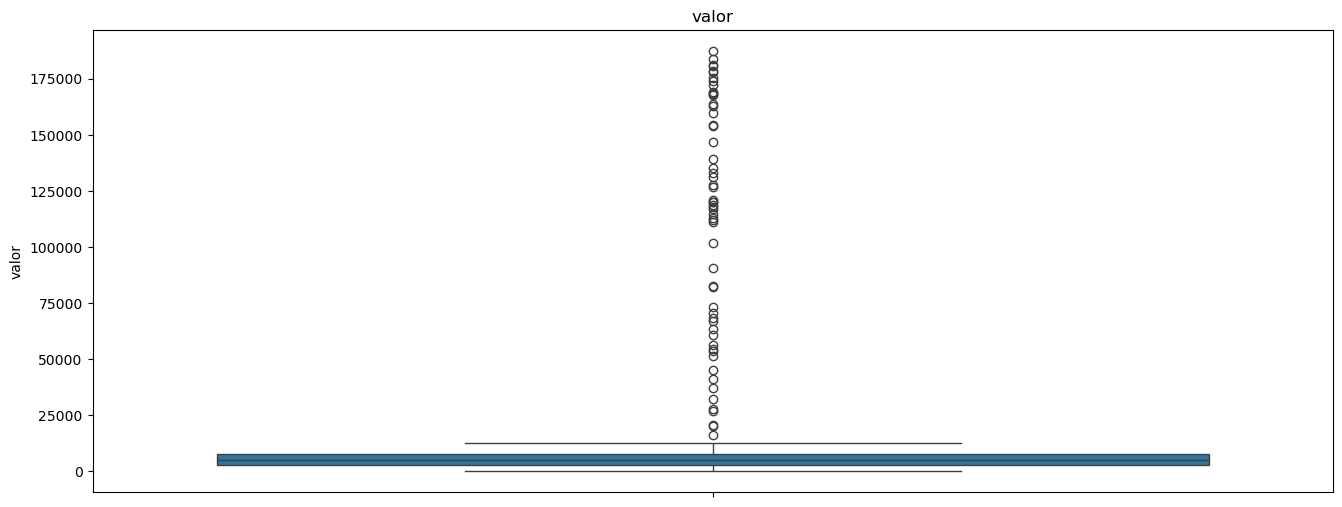

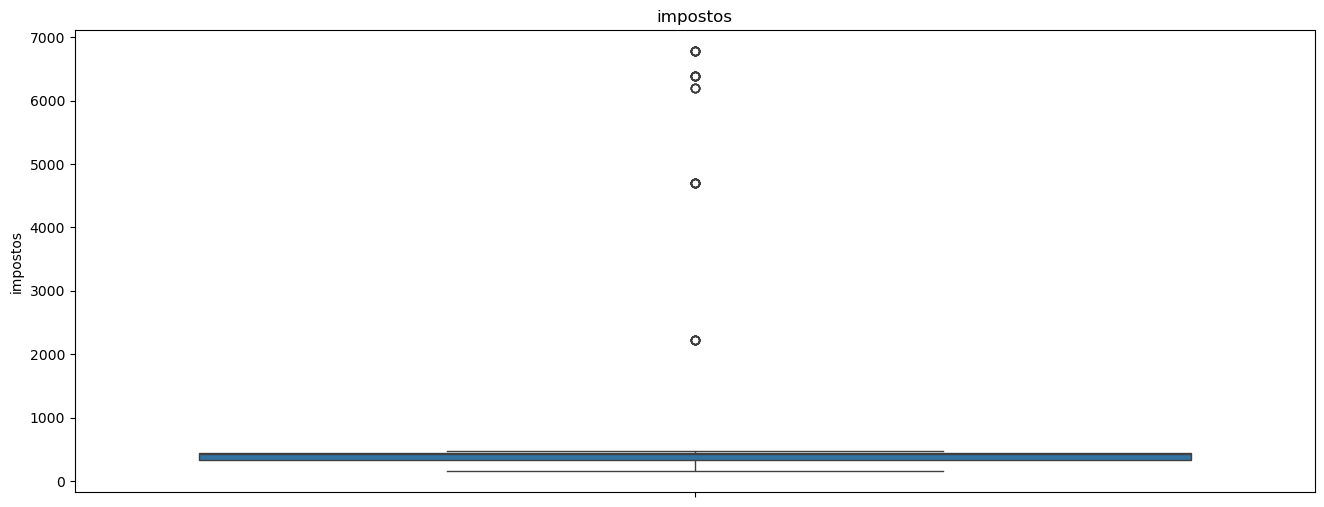

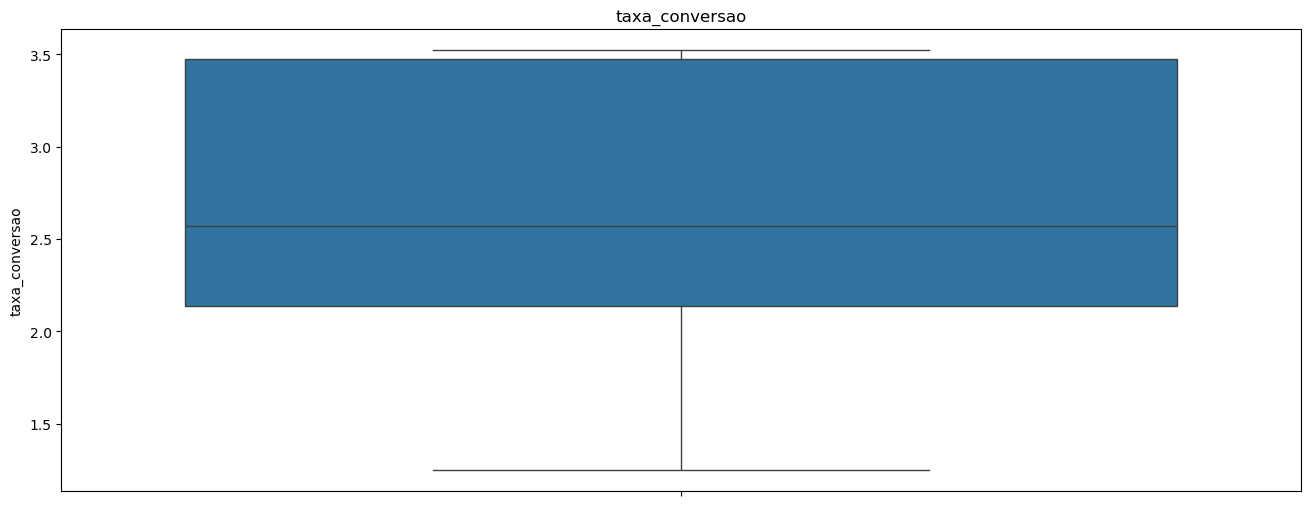

In [14]:
# Identificando valores ausentes graficamente através do boxplot
colunas = ['valor', 'impostos','taxa_conversao']

for col in colunas:
    plt.figure(figsize=(16,6))
    sns.boxplot(data = df, y = col)
    plt.title(col)
    plt.show()

Analise: Possui Outlier no valor e nos impostos

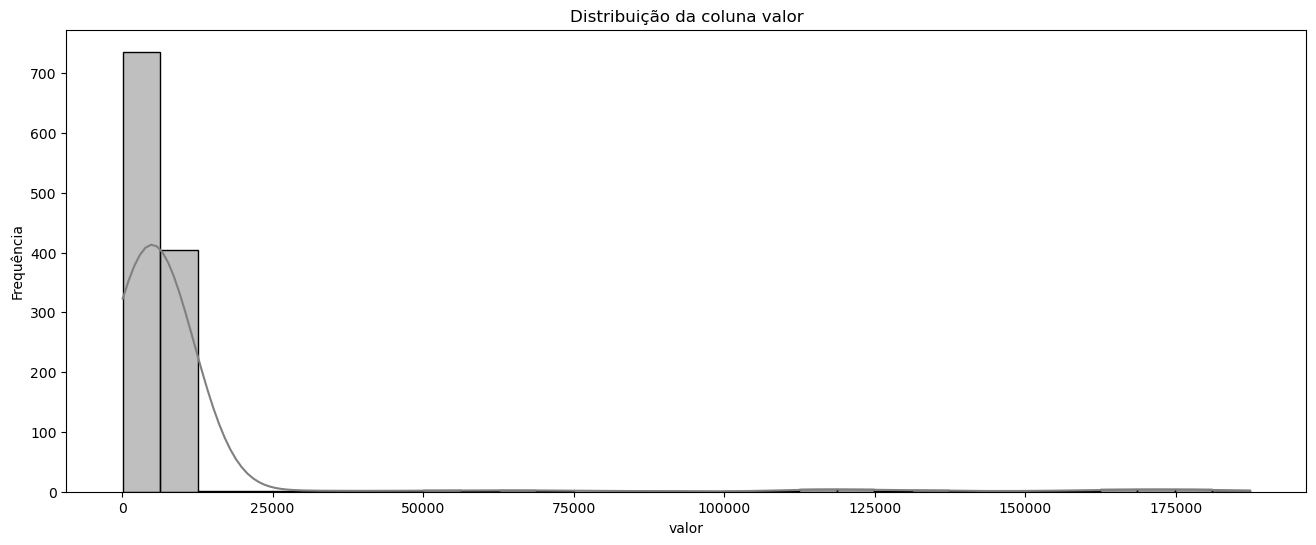

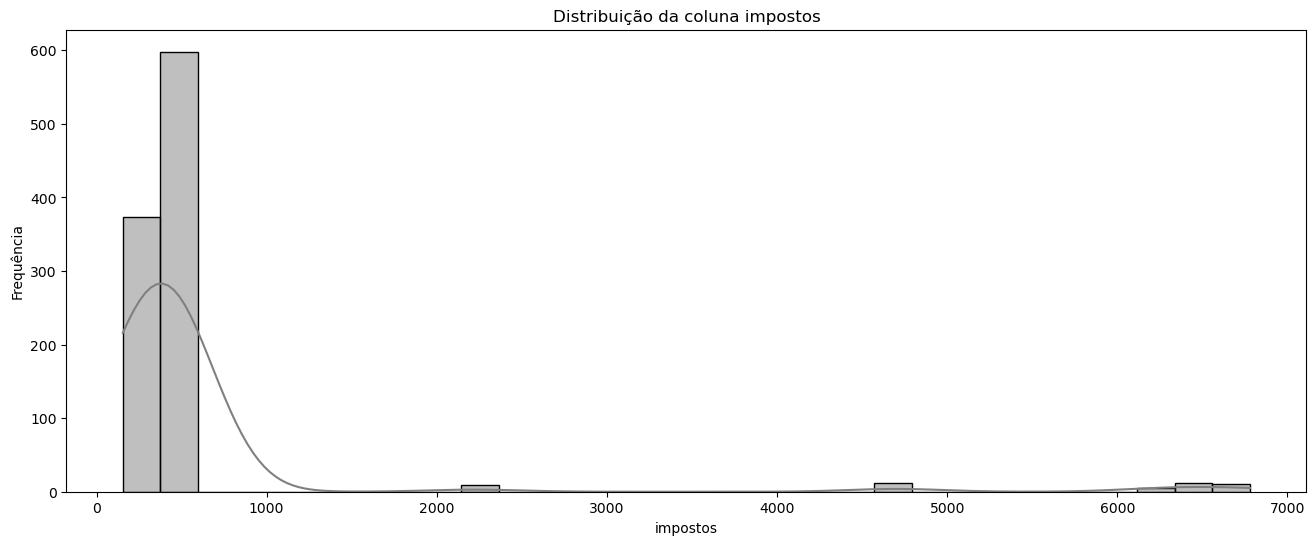

In [15]:
# Grafico de histrograma para a coluna valor e impostos para verificarmos a distribuição dos valores
for col in('valor', 'impostos'):
    plt.figure(figsize=(16,6))
    sns.histplot(data =df, x = col, kde= True, bins=30, color='gray')
    plt.title(f'Distribuição da coluna {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()

Analise: Distribuição assimétrica, em tese não será viável inputar a média para os valores ausentes

In [16]:
# Convertendo o tipo de dados da varável data_lancamento para Datetime
df['data_lancamento'] = pd.to_datetime(df['data_lancamento'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1200 non-null   int64         
 1   data_lancamento    1200 non-null   datetime64[ns]
 2   conta_debito       1200 non-null   object        
 3   conta_credito      1200 non-null   object        
 4   valor              1200 non-null   float64       
 5   documento          1078 non-null   object        
 6   natureza_operacao  1080 non-null   object        
 7   centro_custo       1200 non-null   object        
 8   impostos           1020 non-null   float64       
 9   moeda              947 non-null    object        
 10  taxa_conversao     982 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 103.3+ KB


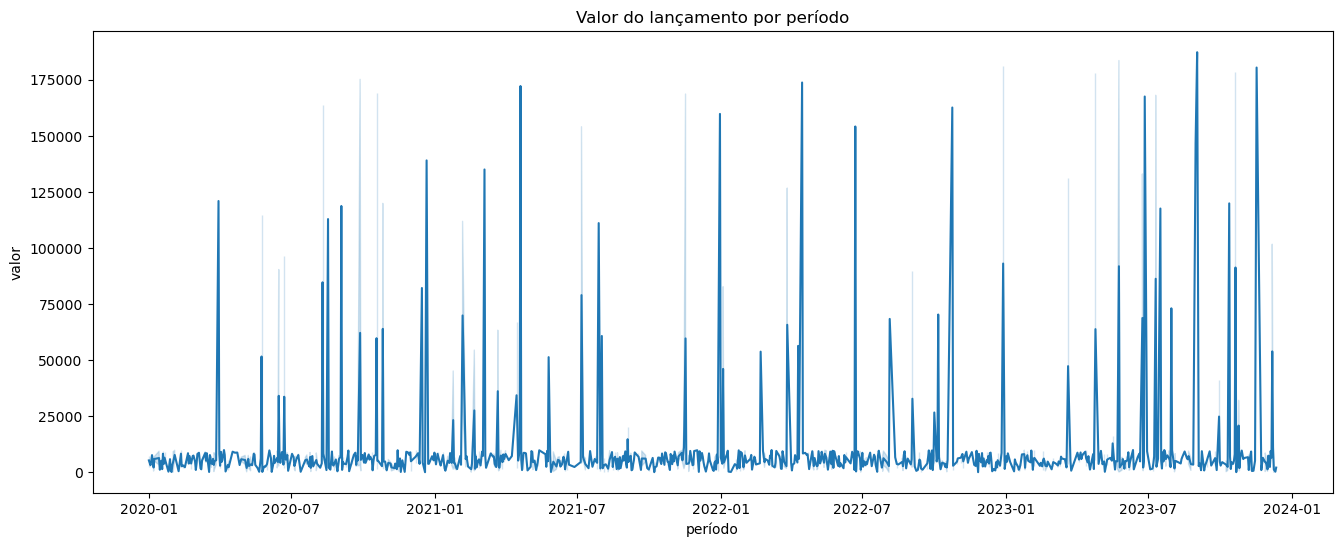

In [18]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x='data_lancamento', y='valor')
plt.title('Valor do lançamento por período')
plt.xlabel('período')
plt.ylabel('valor')
plt.show()

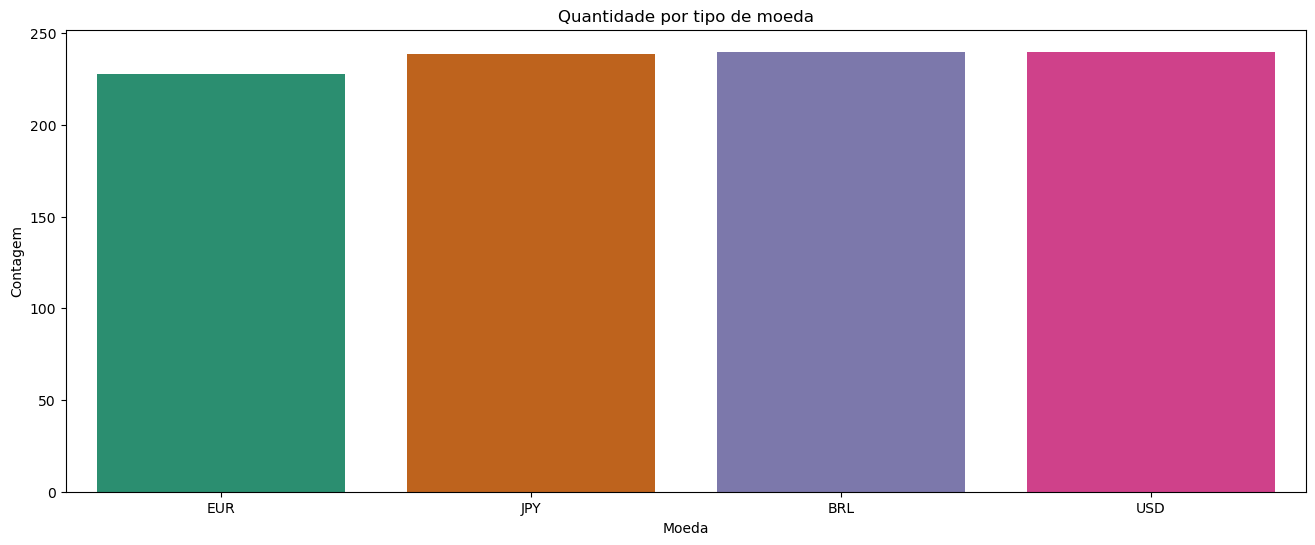

In [19]:
plt.figure(figsize=(16,6))
sns.countplot(data=df,x='moeda',palette = 'Dark2')
plt.title('Quantidade por tipo de moeda')
plt.xlabel('Moeda')
plt.ylabel('Contagem')
plt.show()

In [20]:
# Verificando a distribuição na conta_debito
df['conta_debito'].value_counts().head()

conta_debito
DWAVRL    1
DOT5JM    1
DWDZNC    1
DFKTG5    1
DWHUMG    1
Name: count, dtype: int64

In [21]:
# Verificando a distribuição na conta_credito
df['conta_credito'].value_counts().head()

conta_credito
?         4
CIOVQ6    1
CZGGWF    1
CZ81GI    1
COZD4D    1
Name: count, dtype: int64

In [22]:
# Verificando a distribuição na centro_custo
df['centro_custo'].value_counts().head()

centro_custo
CC5FYA2    1
CC0Q5T3    1
CC5KP7G    1
CCN00IF    1
CCGKFAA    1
Name: count, dtype: int64

## Verificando se há duplicidades 

In [23]:
# Na coluna ID
df['id'].duplicated().sum()

0

In [24]:
# Comparando todo DF (Se uma linha se repete_
df.duplicated().sum()

0

Problemas identificados no dataset:

    - Coluna de data está com o tipo incorreto -> Transformar em datetime
    
    - Valores ausentes em várias colunas -> Aplicar técnicas especificas de acordo com a coluna
    
    - Os atributos valor e Imposto possuem outlier

    - Na coluna contá crédito possui o caracter '?', isso se caracteriza como um valor ausente 

# Tratamento de valores ausentes

### impostos

In [25]:
# Verificando a correlaçção entre as duas variáveis para verificar se é possível preencher o imposto de acordo com a coluna de valor

cor = df[['valor', 'impostos']].corr()

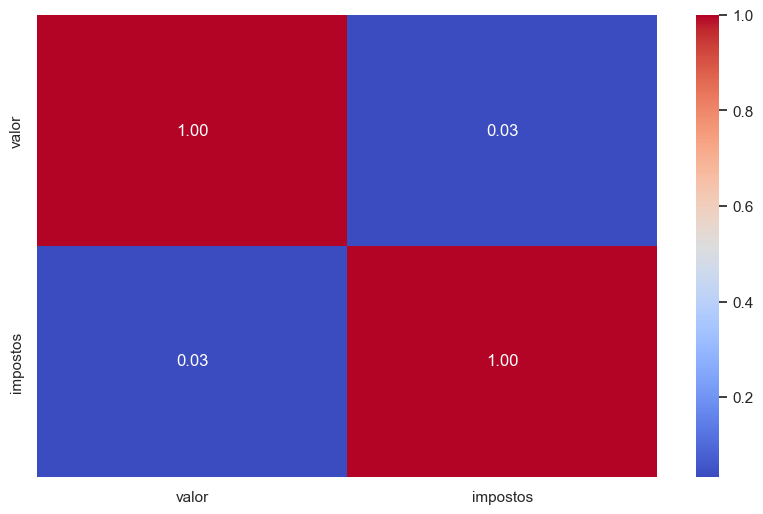

In [81]:
plt.figure(figsize=(10,6))
sns.heatmap(data =cor, annot=True,cmap='coolwarm',fmt= ".2f")
plt.show()

Conclusão: As variáveis valor e impostos não são correlacionadas para esse conjunto de dados, dessa forma não aplicaremos regressão.

Nota: Também não aplicaremos a média devido conter outliers nas variáveis 'impostos'. Optaremos pela mediana por ser menos sensível a outlier

In [27]:
# Aplicando a médiana para preenchimento dos valores ausentes na variável impostos'

df['impostos'].fillna(df['impostos'].median(), inplace=True)
print(f'Imputação da mediana na variável "impostos" realizada com sucesso!!! \n')

Imputação da mediana na variável "impostos" realizada com sucesso!!! 



In [28]:
# Verificando os valores ausentes
verifica_ausentes(df)

,Atributo,Qtd,Percent
0,id,0,0.00
1,data_lancamento,0,0.00
2,conta_debito,0,0.00
3,conta_credito,0,0.00
4,valor,0,0.00
5,documento,122,10.17
6,natureza_operacao,120,10.00
7,centro_custo,0,0.00
8,impostos,0,0.00
9,moeda,253,21.08


### Moeda

In [29]:
# Verificando a distribuição
df['moeda'].value_counts()

moeda
BRL    240
USD    240
JPY    239
EUR    228
Name: count, dtype: int64

Conclusão: Não vamos utilizar a moda para imputação, visto que a distribuição é bem proxíma.

Vamos simplesmente incluir a informação 'Não informado' para os ausentes

In [30]:
# Substituindo os valores ausentes por 'Não informado'
df['moeda'].fillna('Não informado',inplace=True)

In [31]:
# Verificando a distribuição após o tratamento
df['moeda'].value_counts()

moeda
Não informado    253
BRL              240
USD              240
JPY              239
EUR              228
Name: count, dtype: int64

In [32]:
# Verificando os valores ausentes
verifica_ausentes(df)

,Atributo,Qtd,Percent
0,id,0,0.00
1,data_lancamento,0,0.00
2,conta_debito,0,0.00
3,conta_credito,0,0.00
4,valor,0,0.00
5,documento,122,10.17
6,natureza_operacao,120,10.00
7,centro_custo,0,0.00
8,impostos,0,0.00
9,moeda,0,0.00


### taxa_conversao

In [33]:
# Verificando a distribuição
df['taxa_conversao'].value_counts()

taxa_conversao
3.475606    202
2.135300    200
3.523287    197
2.568117    192
1.248029    191
Name: count, dtype: int64

Conclusão: 
    Não vamos utilizar a moda para imputação, visto que a distribuição é bem proxíma.
    Não vamos utilizar a média e mediana para não enviesar os dados.        

Vamos simplesmente incluir a informação 'Outro' para os ausentes

In [34]:
# Substituindo os valores ausentes por 'Outro'

df['taxa_conversao'].fillna('Outro', inplace=True)

In [35]:
# Verificando a distribuição após o tratamento
df['taxa_conversao'].value_counts()

taxa_conversao
Outro       218
3.475606    202
2.1353      200
3.523287    197
2.568117    192
1.248029    191
Name: count, dtype: int64

In [36]:
# Verificando os valores ausentes
verifica_ausentes(df)

,Atributo,Qtd,Percent
0,id,0,0.00
1,data_lancamento,0,0.00
2,conta_debito,0,0.00
3,conta_credito,0,0.00
4,valor,0,0.00
5,documento,122,10.17
6,natureza_operacao,120,10.00
7,centro_custo,0,0.00
8,impostos,0,0.00
9,moeda,0,0.00


### Documento

In [37]:
# Verificando a distribuição
df['documento'].value_counts()

documento
DOCPAXGQ    1
DOC0OG3N    1
DOC496BY    1
DOCA9I67    1
DOCODKBW    1
           ..
DOC65CMR    1
DOCVGBPJ    1
DOCM8C7R    1
DOCKQTH1    1
DOC84WHJ    1
Name: count, Length: 1078, dtype: int64

In [38]:
# temos 1078 valores distintos
df['documento'].nunique()

1078

Conclusão: 
    Não vamos utilizar a moda para imputação, visto a alta quantidade de tipos de documento.       

Vamos simplesmente incluir a informação 'Outro' para os ausentes

In [39]:
# Aplicando a técnica
df['documento'].fillna('Outro', inplace=True)

In [40]:
# Verificando a distribuição
df['documento'].value_counts()

documento
Outro       122
DOCPAXGQ      1
DOC5WHTT      1
DOCG2QNP      1
DOCY4JG3      1
           ... 
DOC65CMR      1
DOCVGBPJ      1
DOCM8C7R      1
DOCKQTH1      1
DOC84WHJ      1
Name: count, Length: 1079, dtype: int64

In [41]:
# Verificando os valores ausentes
verifica_ausentes(df)

,Atributo,Qtd,Percent
0,id,0,0.0
1,data_lancamento,0,0.0
2,conta_debito,0,0.0
3,conta_credito,0,0.0
4,valor,0,0.0
5,documento,0,0.0
6,natureza_operacao,120,10.0
7,centro_custo,0,0.0
8,impostos,0,0.0
9,moeda,0,0.0


### Natureza da operação

In [42]:
# Verificando a distribuição
df['natureza_operacao'].value_counts()

natureza_operacao
OP7JDVK    1
OPN9140    1
OPLUH9G    1
OPJS408    1
OP1O06S    1
          ..
OPXHU9N    1
OPGG4RI    1
OP1DEJ4    1
OP74G3G    1
OPEHT60    1
Name: count, Length: 1080, dtype: int64

In [43]:
# temos 1080 valores distintos
df['natureza_operacao'].nunique()

1080

Conclusão: 
    Não vamos utilizar a moda para inputação, visto a alta quantidade de tipos de documento.       

Vamos simplesmente incluir a informação 'Outra' para os ausentes

In [44]:
# Aplicando a técnica

df['natureza_operacao'].fillna('Outra', inplace= True)

In [45]:
# Verificando a distribuição
df['natureza_operacao'].value_counts()

natureza_operacao
Outra      120
OP7JDVK      1
OPT3QI5      1
OPAPBZJ      1
OP64HWE      1
          ... 
OPXHU9N      1
OPGG4RI      1
OP1DEJ4      1
OP74G3G      1
OPEHT60      1
Name: count, Length: 1081, dtype: int64

In [46]:
# Verificando os valores ausentes
verifica_ausentes(df)

,Atributo,Qtd,Percent
0,id,0,0.0
1,data_lancamento,0,0.0
2,conta_debito,0,0.0
3,conta_credito,0,0.0
4,valor,0,0.0
5,documento,0,0.0
6,natureza_operacao,0,0.0
7,centro_custo,0,0.0
8,impostos,0,0.0
9,moeda,0,0.0


### conta_credito

In [47]:
# identificando '?' na coluna conta_credito

df['conta_credito'].isin(['?']).sum()

4

In [48]:
# A coluna possui 1197 valores distintos
df['conta_credito'].nunique()

1197

Conclusão: 
    Não vamos utilizar a moda para imputação, visto a quantidade de tipos de contas de crédito.       

Vamos incluir a informação 'Alerta - Conta não identificada' para os ausentes (?), visto que contabilmente há um risco enorme preencher com outra conta, precisaria de uma análise profunda da área de negócios para identificar corretamente a conta apropriada.

In [49]:
# Substituindo o caractere '?' por 'Alerta - Conta não identificada'
df['conta_credito'].replace('?','Alerta - Conta não identificada', inplace=True)

In [50]:
# Verificando após o tratamento

df['conta_credito'].isin(['?']).sum()

0

Pronto - Tratamento de valores ausentes realizado com sucesso!!!

## Tratamento de outliers

In [51]:
# função para tratamento

def retira_outliers(df, coluna):
    q1 = df[coluna].quantile(0.25)
    q3 = df[coluna].quantile(0.75)
    iqr = q3-q1
    
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q1 + 1.5 * iqr
    
    # Filtrando os outliers
    df = df[~((df[coluna] < lim_inf) | (df[coluna] > lim_sup))]
    
    print(f'Tratamento de outliers na coluna {coluna} realizado com sucesso!!!')
    
    return df   

In [52]:
# Aplicando a função na coluna 'Valor'

df = retira_outliers(df,'valor')

Tratamento de outliers na coluna valor realizado com sucesso!!!


In [53]:
df.shape

(1141, 11)

In [54]:
# Aplicando a função na coluna 'Valor'
df = retira_outliers(df,'impostos')

Tratamento de outliers na coluna impostos realizado com sucesso!!!


In [55]:
df.shape

(1096, 11)

## Medidas estatisticas após os tratamentos

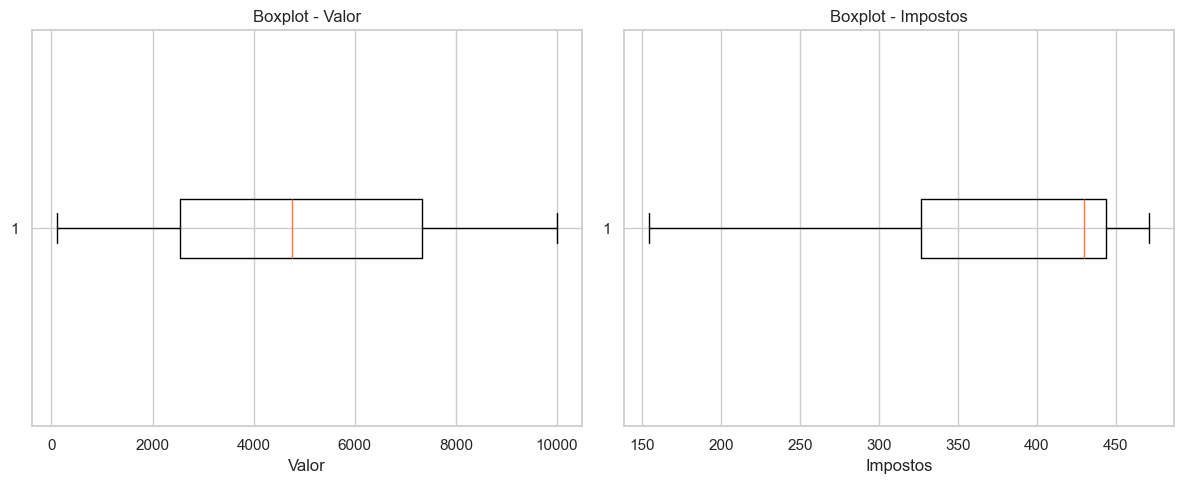

In [73]:
# Identificando valores ausentes graficamente através do boxplot
sns.set(style ='whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Gráfico da coluna 'valor'
axes[0].boxplot(df['valor'], vert=False)
axes[0].set_title('Boxplot - Valor')
axes[0].set_xlabel('Valor')

# Gráfico da coluna 'impostos'
axes[1].boxplot(df['impostos'], vert=False)
axes[1].set_title('Boxplot - Impostos')
axes[1].set_xlabel('Impostos')

plt.tight_layout()
plt.show()

In [58]:
df.describe(include='all')

,id,data_lancamento,conta_debito,conta_credito,valor,documento,natureza_operacao,centro_custo,impostos,moeda,taxa_conversao
count,1096.000000,1096,1096,1096,1096.000000,1096,1096,1096,1096.000000,1096,1096
unique,NaN,NaN,1096,1093,NaN,985,992,1096,NaN,5,6
top,NaN,NaN,DWAVRL,Alerta - Conta não identificada,NaN,Outro,Outra,CC5FYA2,NaN,Não informado,Outro
freq,NaN,NaN,1,4,NaN,112,105,1,NaN,226,206
mean,596.474453,2021-12-05 18:48:36.788321280,NaN,NaN,4946.917280,NaN,NaN,NaN,378.120393,NaN,NaN
min,1.000000,2020-01-01 00:00:00,NaN,NaN,105.410000,NaN,NaN,NaN,154.263980,NaN,NaN
25%,293.750000,2020-11-15 00:00:00,NaN,NaN,2534.307500,NaN,NaN,NaN,326.499880,NaN,NaN
50%,591.500000,2021-12-03 00:00:00,NaN,NaN,4763.290000,NaN,NaN,NaN,430.155339,NaN,NaN
75%,902.250000,2022-12-03 00:00:00,NaN,NaN,7334.382500,NaN,NaN,NaN,444.132520,NaN,NaN
max,1200.000000,2023-12-12 00:00:00,NaN,NaN,9998.100000,NaN,NaN,NaN,471.092360,NaN,NaN


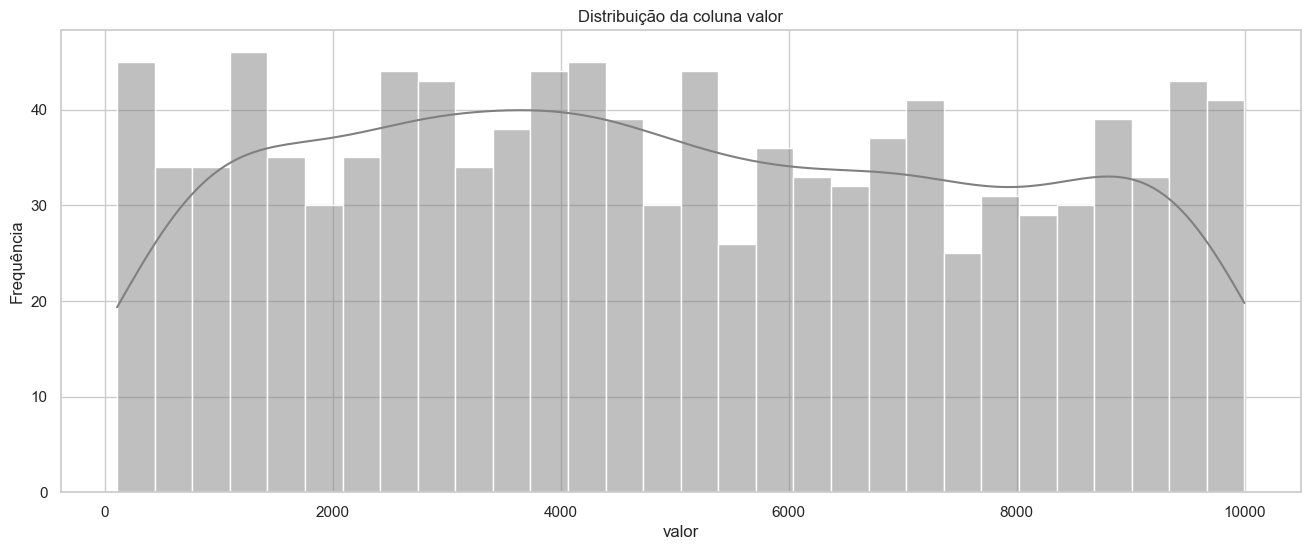

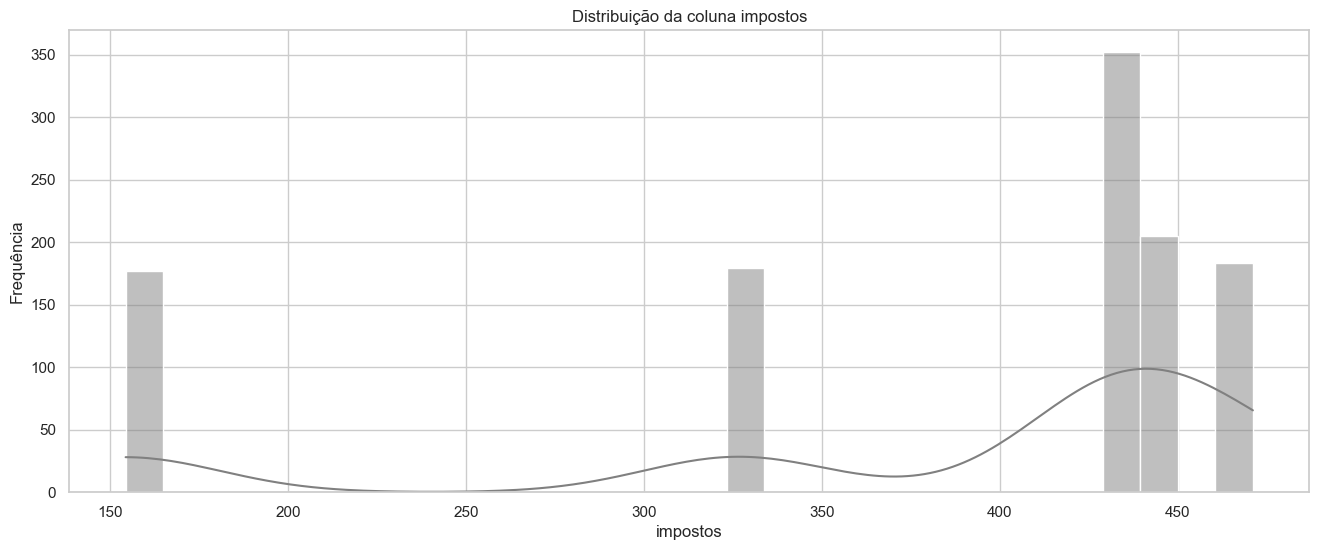

In [63]:
# Distribuição das variáveis valor e impostos

for col in('valor', 'impostos'):
    plt.figure(figsize=(16,6))
    sns.histplot(data =df, x = col, kde= True, bins=30, color='gray')
    plt.title(f'Distribuição da coluna {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()

In [70]:
# Coeficiente de assimetria da variável valor
df['valor'].skew()

0.08824256916354584

In [72]:
# Coeficiente de assimetria da variável impostos
df['impostos'].skew()

-1.2738748643839035

Text(0.5, 1.0, 'Valor x impostos')

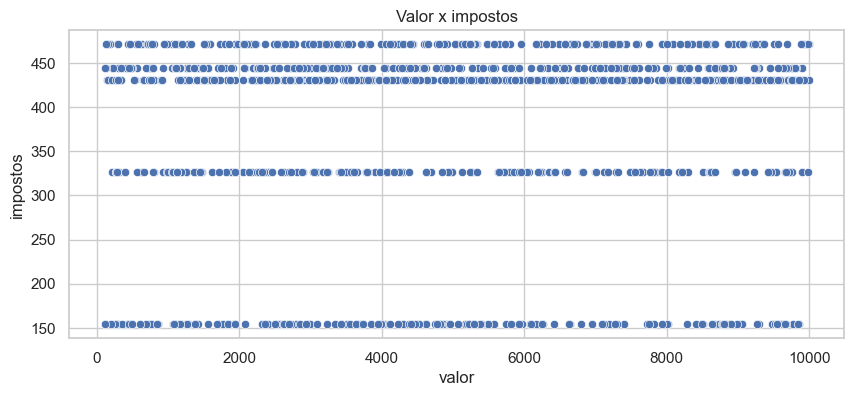

In [93]:
# Gráfico de dispersão entre valor e impostos

plt.figure(figsize=(10,4))
sns.scatterplot(data = df, x ='valor' , y ='impostos')
plt.title('Valor x impostos')

Analise: Variáveis não possuem correlação: Valor do imposto independe do valor de lançamento

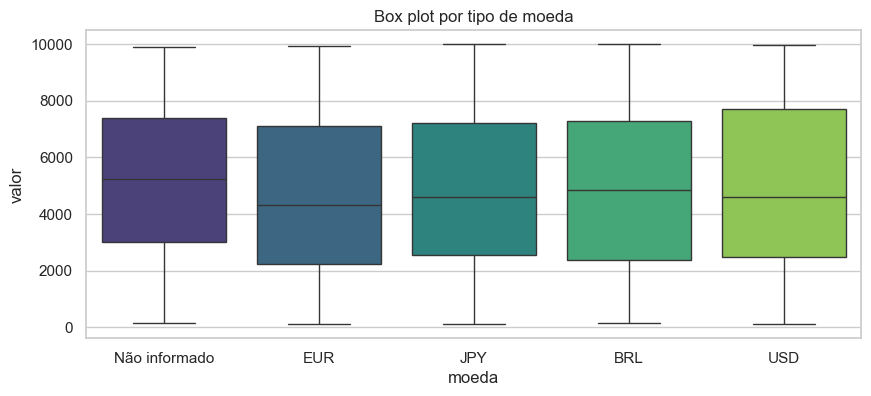

In [99]:
plt.figure(figsize=(10,4))
sns.boxplot(data = df, x ='moeda' , y ='valor',palette='viridis')
plt.title('Box plot por tipo de moeda')
plt.show()

# Engenharia de atributos

In [82]:
# Criando uma nova coluna a partir da data_lancamento
data_minima = df['data_lancamento'].min()
df['dias desde a data de lançamento'] = (df['data_lancamento'] - data_minima).dt.days

In [84]:
df.head()

,id,data_lancamento,conta_debito,conta_credito,valor,documento,natureza_operacao,centro_custo,impostos,moeda,taxa_conversao,dias desde a data de lançamento
0,1,2022-02-27,DWAVRL,CIOVQ6,5533.25,DOCPAXGQ,OP7JDVK,CC5FYA2,444.13252,Não informado,3.475606,788
1,2,2022-05-11,D8TF53,CV9Y0V,7180.37,DOCBXZXG,OPXSY64,CCLH4R9,471.09236,EUR,3.523287,861
2,3,2020-03-23,D0TZCE,CELQSH,6067.36,DOCF5ITC,OPTDE9B,CCDG8CJ,326.49988,JPY,3.523287,82
3,4,2021-06-14,DOGLK7,CDFEMS,5494.34,DOCZRS1U,Outra,CC98G2K,471.09236,JPY,3.523287,530
4,5,2022-11-13,DHL0I5,CRU97G,4294.18,Outro,OP62LG1,CCZD80Y,154.26398,EUR,3.523287,1047


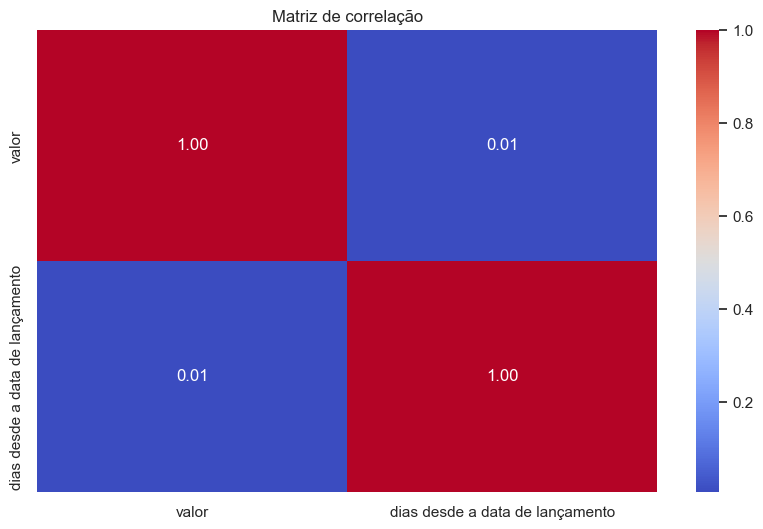

In [88]:
# Verificando a correlação entre o valor e nova coluna

correlacao = df[['valor','dias desde a data de lançamento']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(data=correlacao, cmap='coolwarm', annot=True, fmt= ".2f")
plt.title('Matriz de correlação')
plt.show()

Análise: Não há correlação entre as duas variáveis

# Trabalho concluído

In [102]:
%watermark -a "Guilherme"

Author: Guilherme



In [104]:
%watermark --iversions

matplotlib: 3.9.2
tqdm      : 4.66.5
scipy     : 1.13.1
missingno : 0.5.2
seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.2.2
watermark : 2.5.0

